# K-Means Clustering

This notebook demonstrates how to use the `KMeans` implementation in `rice_ml.unsupervised_learning`.

W've already shown KMeans plot result in DBSCAN notebook, and in this notebook we will:
1. Load the Iris dataset (for demonstration).
2. Standardize features (important for distance-based methods).
3. Fit K-Means with a chosen `k`.
4. Visualize clustering results and compare with the ground-truth labels (reference only).

## 1. Setup

We import:
- NumPy and Matplotlib for computation and visualization
- `standardize` from our preprocessing module
- `KMeans` from our `rice_ml` package

We also add the repo `src/` directory to `sys.path` so the notebook can import `rice_ml` when run directly.

In [ ]:
from __future__ import annotations

import sys
from pathlib import Path

import itertools
import numpy as np
import matplotlib.pyplot as plt

# --- Make sure we can import rice_ml from src/ ---
root = Path.cwd()
while root != root.parent and not (root / "src" / "rice_ml").exists():
    root = root.parent

if not (root / "src" / "rice_ml").exists():
    raise RuntimeError(
        "Could not find 'src/rice_ml'. "
        "Run this notebook inside the repo folder structure, or install the package."
    )

sys.path.insert(0, str(root / "src"))

from rice_ml.processing.preprocessing import standardize
from rice_ml.unsupervised_learning.k_means_clustering import KMeans

np.random.seed(42)
print("Repo root:", root)
print("Imports OK.")


Repo root: c:\Users\sutt6\OneDrive\Desktop\CMOR438\CMOR438
Imports OK.


## 2. Load data (Iris)

We use the classic Iris dataset (150 samples, 4 numeric features, 3 species).
The species labels are **not** used by K-Means during training; we only use them later as a reference.


In [2]:
# --- Load Iris dataset (sklearn only used in notebooks for convenience) ---
try:
    from sklearn.datasets import load_iris
except ImportError as e:
    raise ImportError(
        "scikit-learn is required for this notebook dataset loading. "
        "Install it in your .venv: pip install scikit-learn"
    ) from e

iris = load_iris()
X = iris.data.astype(float)          # shape (150, 4)
y = iris.target.astype(int)          # shape (150,)
feature_names = list(iris.feature_names)
target_names = list(iris.target_names)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Features:", feature_names)
print("Targets:", target_names)
print("Class counts:", {i: int((y == i).sum()) for i in np.unique(y)})


X shape: (150, 4)
y shape: (150,)
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Targets: [np.str_('setosa'), np.str_('versicolor'), np.str_('virginica')]
Class counts: {np.int64(0): 50, np.int64(1): 50, np.int64(2): 50}


## 3. Standardize + 2D view

K-Means uses distances, so feature scale matters a lot.
We will:

- pick two features for a 2D visualization
- standardize them with z-score standardization
- plot the ground-truth labels as a reference (not used for training)


X2 shape: (150, 2)
Mean after standardize (approx): [-4.73695157e-16 -2.84217094e-16]
Std after standardize (approx): [1. 1.]


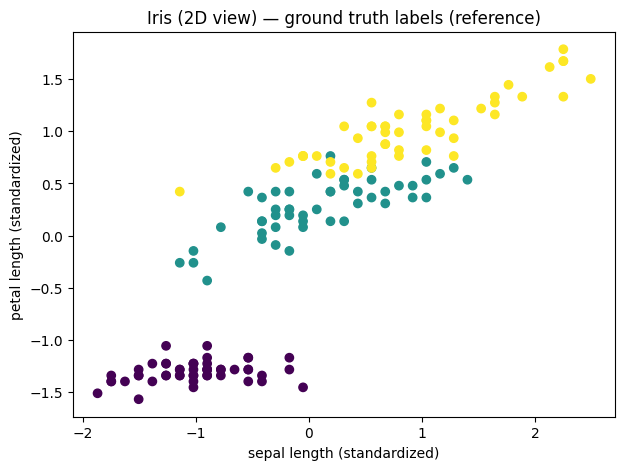

In [3]:
# Pick two features for a clean 2D visualization
idx_x = feature_names.index("sepal length (cm)")
idx_y = feature_names.index("petal length (cm)")

X2 = X[:, [idx_x, idx_y]]  # shape (150, 2)
X2_std, params = standardize(X2, return_params=True)

print("X2 shape:", X2.shape)
print("Mean after standardize (approx):", X2_std.mean(axis=0))
print("Std after standardize (approx):", X2_std.std(axis=0))

# Ground truth plot (reference only)
plt.figure(figsize=(7, 5))
plt.scatter(X2_std[:, 0], X2_std[:, 1], c=y)
plt.xlabel("sepal length (standardized)")
plt.ylabel("petal length (standardized)")
plt.title("Iris (2D view) — ground truth labels (reference)")
plt.show()


## 4. Fit K-Means (k=n_clusters=3)

We now run K-Means on the standardized 2D features.

- `n_clusters=3` because Iris has three species (used only as a reference)
- K-Means does **not** use labels during training
- We print cluster sizes and plot the result


In [6]:
# Fit K-Means
km = KMeans(n_clusters=3, max_iter=100, tol=1e-4, random_state=42)
km.fit(X2_std)

labels_kmeans = km.labels_
centers = km.cluster_centers_

unique, counts = np.unique(labels_kmeans, return_counts=True)
print("KMeans clusters:", len(unique))
print("KMeans sizes:", dict(zip(unique.tolist(), counts.tolist())))
print("centers shape:", centers.shape)
print("inertia:", km.inertia_)
print("n_iter:", km.n_iter_)


KMeans clusters: 3
KMeans sizes: {0: 43, 1: 53, 2: 54}
centers shape: (3, 2)
inertia: 43.03469199603469
n_iter: 16


## 5. Visualize K-Means result

We plot the standardized 2D feature space, colored by cluster label.
Cluster centers are marked with stars.


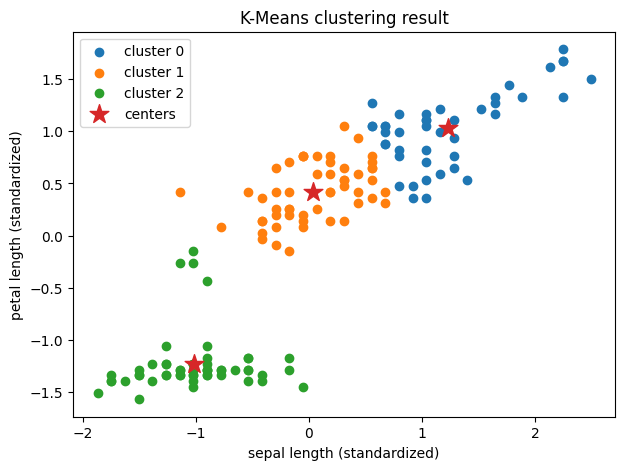

In [7]:
plt.figure(figsize=(7, 5))

for lab in np.unique(labels_kmeans):
    mask = labels_kmeans == lab
    plt.scatter(X2_std[mask, 0], X2_std[mask, 1], label=f"cluster {lab}")

plt.scatter(centers[:, 0], centers[:, 1], marker="*", s=200, label="centers")

plt.xlabel("sepal length (standardized)")
plt.ylabel("petal length (standardized)")
plt.title("K-Means clustering result")
plt.legend()
plt.show()


## Compare with ground truth

K-Means does not rely on labels when fitting the model. However, the Iris dataset provides true class labels (y) for the three species. We treat these labels as a post-hoc reference to qualitatively and quantitatively assess how well the clustering aligns with the real categories.

In [ ]:

# y: iris ground truth labels (0,1,2)
y_true = y
y_pred = labels_kmeans  # from your fitted KMeans on X2_std

classes = np.unique(y_true)
clusters = np.unique(y_pred)

def best_label_mapping(y_true, y_pred):
    """Find the cluster->class mapping that maximizes accuracy (small K only)."""
    classes = np.unique(y_true)
    clusters = np.unique(y_pred)

    if len(classes) != len(clusters):
        return None, None, None  # cannot do 1-1 mapping cleanly

    best_acc = -1.0
    best_map = None
    best_mapped = None

    for perm in itertools.permutations(classes):
        mapping = {clusters[i]: perm[i] for i in range(len(clusters))}
        mapped = np.vectorize(mapping.get)(y_pred)
        acc = float((mapped == y_true).mean())
        if acc > best_acc:
            best_acc = acc
            best_map = mapping
            best_mapped = mapped

    return best_map, best_acc, best_mapped


def confusion_matrix_np(y_true, y_pred, n_classes):
    cm = np.zeros((n_classes, n_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[int(t), int(p)] += 1
    return cm


best_map, best_acc, y_mapped = best_label_mapping(y_true, y_pred)

print("Best mapping (cluster -> class):", best_map)
print("Best-mapped accuracy (reference):", best_acc)

cm = confusion_matrix_np(y_true, y_mapped, n_classes=len(classes))
print("Confusion matrix (rows=true, cols=pred after mapping):\n", cm)

# Optional: ARI from sklearn (nice clustering metric, label-invariant)
try:
    from sklearn.metrics import adjusted_rand_score
    ari = adjusted_rand_score(y_true, y_pred)
    print("Adjusted Rand Index (ARI):", ari)
except Exception:
    print("sklearn not available -> skipped ARI")



Best mapping (cluster -> class): {np.int64(0): np.int64(2), np.int64(1): np.int64(1), np.int64(2): np.int64(0)}
Best-mapped accuracy (reference): 0.8066666666666666
Confusion matrix (rows=true, cols=pred after mapping):
 [[50  0  0]
 [ 4 37  9]
 [ 0 16 34]]
Adjusted Rand Index (ARI): 0.5634459557571242


## Interpretation

### What we observe in the 2D plots
- In the **ground truth** plot, one class forms a clearly separated cluster (the bottom-left group), while the other two classes overlap substantially in this 2D feature space.
- In the **K-Means result**, the algorithm finds **3 compact clusters** and places centers (red stars) near the densest regions. This matches the “spherical / compact cluster” assumption of K-Means.

### Quantitative comparison (reference only)
Because K-Means is unsupervised, cluster IDs (0/1/2) do not correspond to the true class IDs. After finding the **best 1–1 mapping** between clusters and classes, we get:

- **Best-mapped accuracy (reference):** 0.807  
- **Adjusted Rand Index (ARI):** 0.563  

These values indicate that K-Means recovers a meaningful structure, but it is not perfect—mainly due to overlap between two of the species in this 2D view.

### Where the errors come from (using the confusion matrix)
Confusion matrix (rows = true class, cols = predicted after mapping):

- True class 0: 50/50 correct (perfectly separated in these two features).
- Most errors happen between true classes 1 and 2:
  - true class 1 predicted as 2: 9
  - true class 2 predicted as 1: 16

This matches the visual overlap between these groups: in a 2D projection, the boundary K-Means learns will inevitably mislabel some points.
